In [72]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings("ignore")

In [73]:
# Load the dataset
df = pd.read_csv("C:/Users/linda/Downloads/Nono/bank-full.csv", delimiter = ';')

# Display the first few rows of the dataset
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [74]:
# Check the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [75]:
df.rename(columns={'contact':'contact type'}, inplace= True)
df.rename(columns={'day':'last day of contact'}, inplace= True)
df.rename(columns={'month':'last month of contact'}, inplace= True)
df.rename(columns={'duration':'duration of call (seconds)'}, inplace= True)
df.rename(columns={'campaign':'times contacted this campaign'}, inplace= True)
df.rename(columns={'pdays':'days passed since last contact'}, inplace= True)
df.rename(columns={'previous':'times contacted before current campaign'}, inplace= True)
df.rename(columns={'poutcome':'previous campaign outcome'}, inplace= True)
df.rename(columns={'y':'outcome'}, inplace= True)

df['days passed since last contact'].replace(-1, np.nan, inplace=True)

In [76]:
features = ['age','job', 'marital', 'education', 'default', 'balance', 'housing', 'loan','times contacted this campaign', 'days passed since last contact', 'previous campaign outcome', 'outcome']
X = df[features]

In [77]:
# Define feature groups
categorical_features = ['job', 'marital', 'default', 'housing', 'loan', 'previous campaign outcome']
ordinal_features = ['education']  # Assuming it has an order (e.g., primary < secondary < tertiary)
numerical_features = ['age', 'balance', 'days passed since last contact', 'times contacted this campaign']

# Separate feature types from the dataset
X_categorical = X[categorical_features]
X_ordinal = X[ordinal_features]
X_numerical = X[numerical_features]
y_categorical = X['outcome']

# Handle Ordinal Encoding for 'education'
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
X_ordinal['education_encoded'] = ordinal_encoder.fit_transform(X_ordinal[['education']])

# One-Hot Encoding for categorical features
X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# Combine all features
X_final = pd.concat([
    X_categorical_encoded,        # Add one-hot encoded categorical features
    X_ordinal['education_encoded'],  # Add ordinal-encoded 'education'
    X_numerical# Add numerical features
], axis=1)

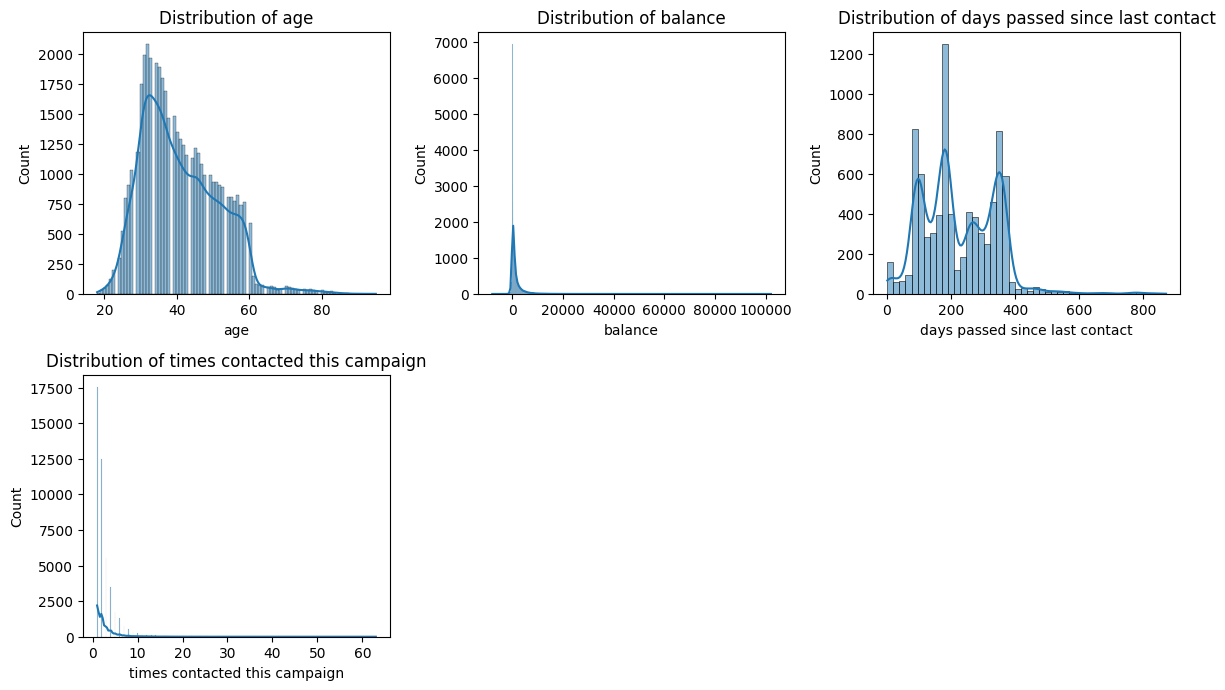

In [78]:
# Exploratory Data Analysis (EDA)

# Histograms for numerical features
plt.figure(figsize=(12, 10))

for i, feature in enumerate(X_numerical, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    
plt.tight_layout()
plt.show()

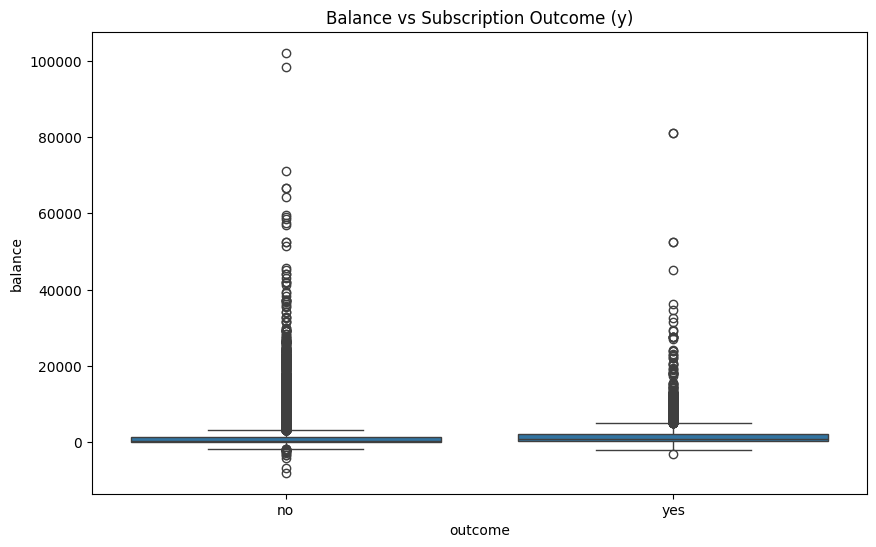

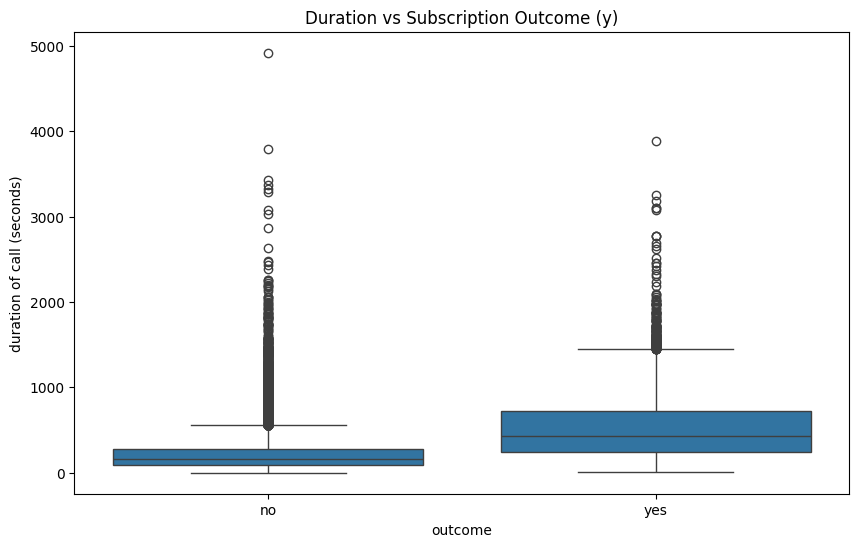

In [79]:
# Boxplots to check distribution of numerical features across categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='outcome', y='balance', data=df)
plt.title('Balance vs Subscription Outcome (y)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='outcome', y='duration of call (seconds)', data=df)
plt.title('Duration vs Subscription Outcome (y)')
plt.show()

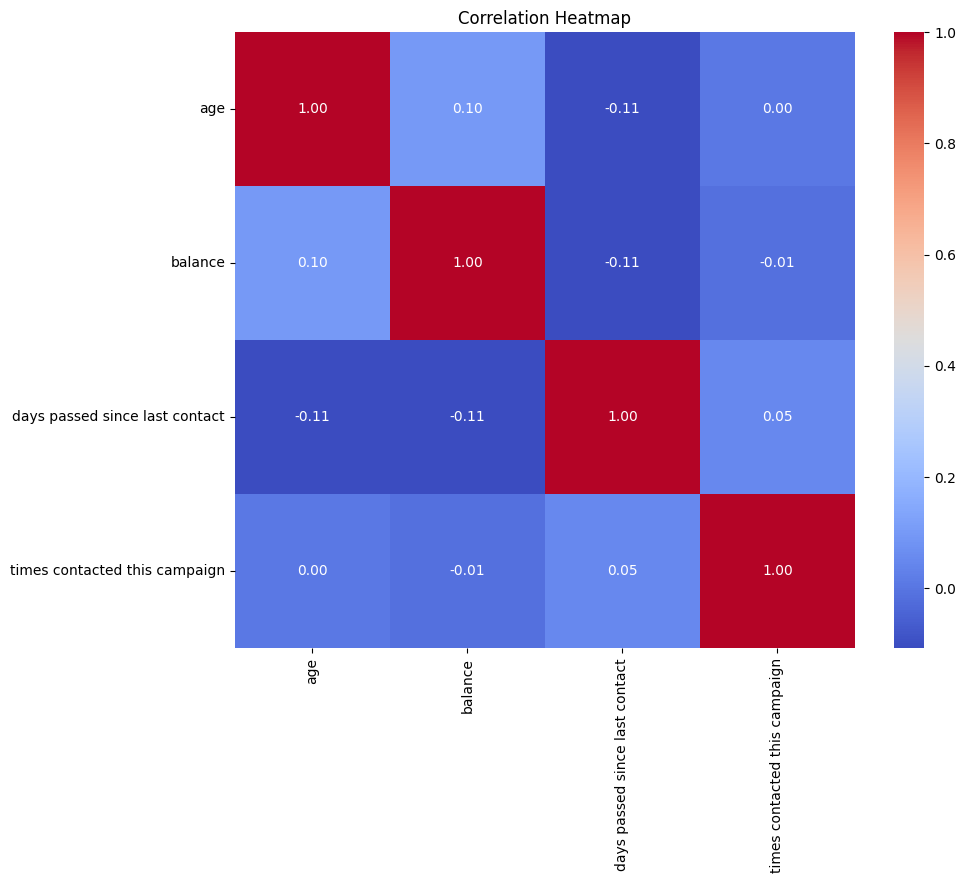

In [80]:
# Correlation matrix for numerical features
correlation_matrix = X_numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [83]:
X_final.fillna(X_final.median(), inplace=True) 

# Scale the numerical data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_final)

# Create a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=X_final.columns)

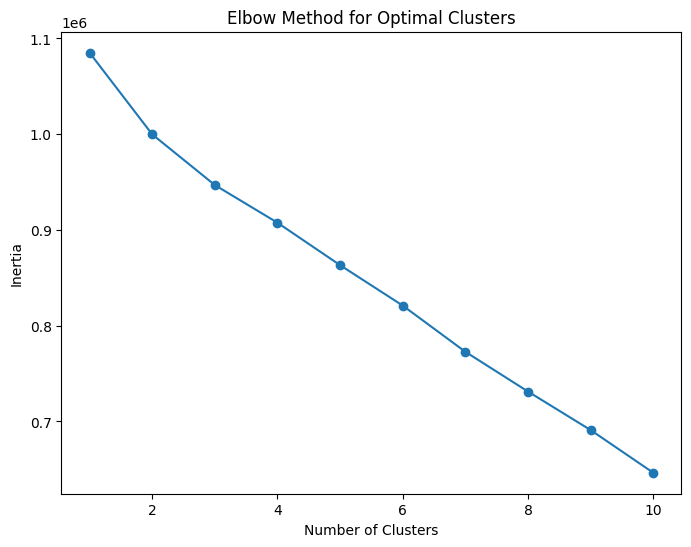

In [84]:
# Clustering: KMeans
# Elbow method to determine optimal clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [85]:
# Apply KMeans clustering with the optimal number of clusters (e.g., 4 from the elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df)


# Show the first few rows with cluster labels
scaled_df.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,loan_yes,previous campaign outcome_other,previous campaign outcome_success,previous campaign outcome_unknown,education_encoded,age,balance,days passed since last contact,times contacted this campaign,Cluster
0,-0.523740,-0.184415,-0.16793,1.944270,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,...,-0.436803,-0.205972,-0.185948,0.472519,1.206484,1.606965,0.256419,-0.110178,-0.569351,0
1,-0.523740,-0.184415,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,2.225121,-0.172266,...,-0.436803,-0.205972,-0.185948,0.472519,-0.077715,0.288529,-0.437895,-0.110178,-0.569351,1
2,-0.523740,5.422561,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,...,2.289359,-0.205972,-0.185948,0.472519,-0.077715,-0.747384,-0.446762,-0.110178,-0.569351,0
3,1.909346,-0.184415,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,...,-0.436803,-0.205972,-0.185948,0.472519,-2.646114,0.571051,0.047205,-0.110178,-0.569351,0
4,-0.523740,-0.184415,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,...,-0.436803,-0.205972,-0.185948,0.472519,-2.646114,-0.747384,-0.447091,-0.110178,-0.569351,2


In [86]:
# Feature Engineering
scale_features = scaled_df.drop(columns=['Cluster'])

# Handle missing values
scale_features = scale_features.apply(pd.to_numeric, errors='coerce')

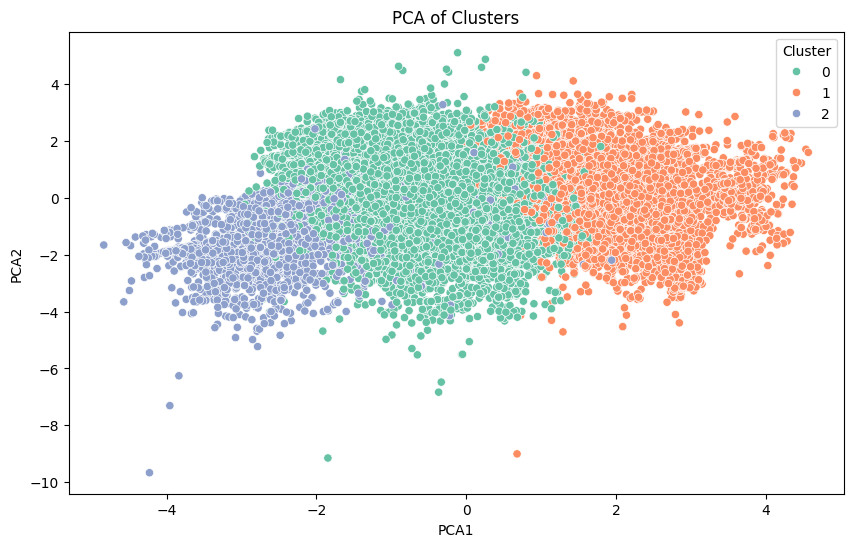

In [87]:
# Perform PCA for dimensionality reduction (2D)
#scaled_df.drop(columns=['Cluster'])
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scale_features)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = scaled_df['Cluster']

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='Set2')
plt.title('PCA of Clusters')
plt.show()

               age      balance  days passed since last contact  \
Cluster                                                           
0        42.292392  1338.616131                      230.101641   
1        33.384883  1288.118639                      225.806166   
2        55.998127  1795.422953                      178.197289   

         times contacted this campaign  
Cluster                                 
0                             2.837541  
1                             2.651207  
2                             2.575976  


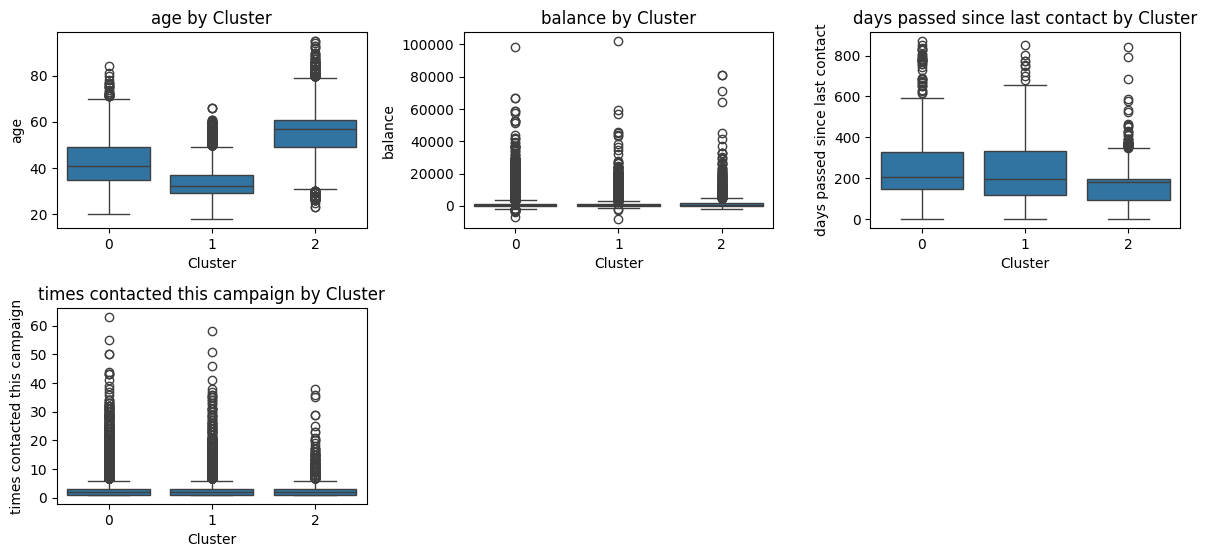

In [88]:
df['Cluster'] = scaled_df['Cluster']

# Cluster profiling: Analyzing the mean values of numerical features for each cluster
cluster_profile = df.groupby('Cluster')[numerical_features].mean()
print(cluster_profile)

# Visualizing the characteristics of each cluster using boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')

plt.tight_layout()
plt.show()

Cluster Sizes:
Cluster
0    28838
1    12635
2     3738
Name: count, dtype: int64


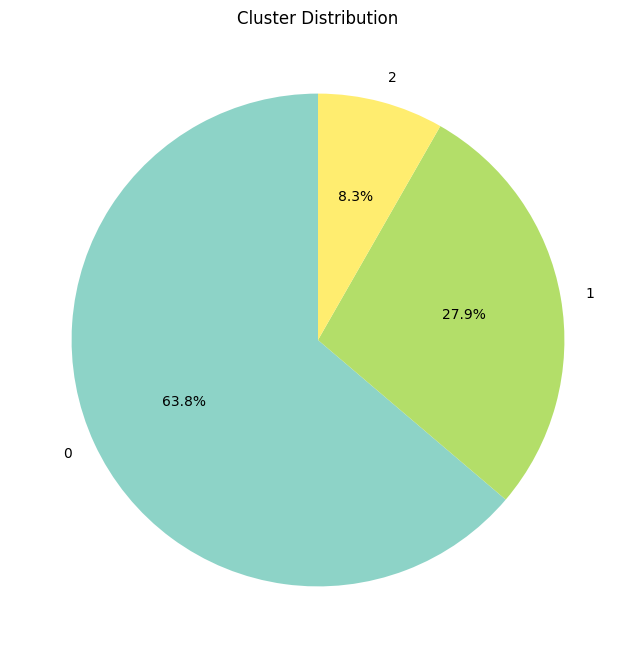

In [89]:
# Analyzing the size of each cluster
cluster_sizes = df['Cluster'].value_counts().sort_index()
print(f'Cluster Sizes:\n{cluster_sizes}')

# Visualizing the distribution of clusters using a pie chart
plt.figure(figsize=(8, 8))
cluster_sizes.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Cluster Distribution')
plt.ylabel('')
plt.show()


In [90]:
# Add cluster labels to the dataframe
scaled_df['Cluster'] = df['Cluster']
scaled_df['outcome'] = X['outcome']

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94     11966
           1       0.52      0.21      0.29      1598

    accuracy                           0.88     13564
   macro avg       0.71      0.59      0.62     13564
weighted avg       0.86      0.88      0.86     13564



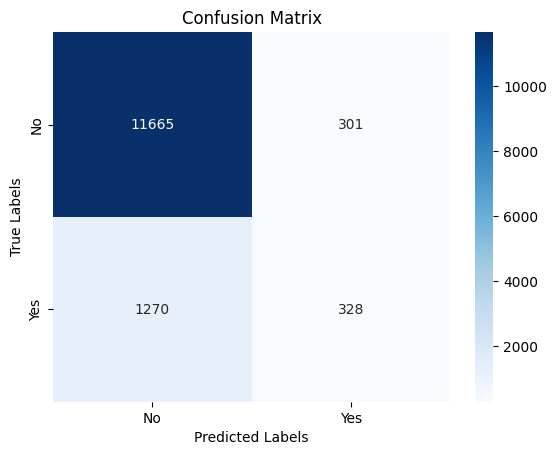

Accuracy: 0.8841787083456207


In [91]:
# Encode target variable 'outcome' ('yes' as 1, 'no' as 0)
scaled_df['outcome_encoded'] = scaled_df['outcome'].map({'yes': 1, 'no': 0})

# Define the feature matrix A and target vector y
A = scaled_df.drop(columns=['outcome', 'outcome_encoded', 'Cluster'])  # Drop unnecessary columns
y = scaled_df['outcome_encoded']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.3, random_state=42)

# Feature Importance Using Random Forest

# Train a Random Forest classifier on the data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_true = y_test

# Classification Report for precision, recall, f1-score
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using Seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Accuracy Score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

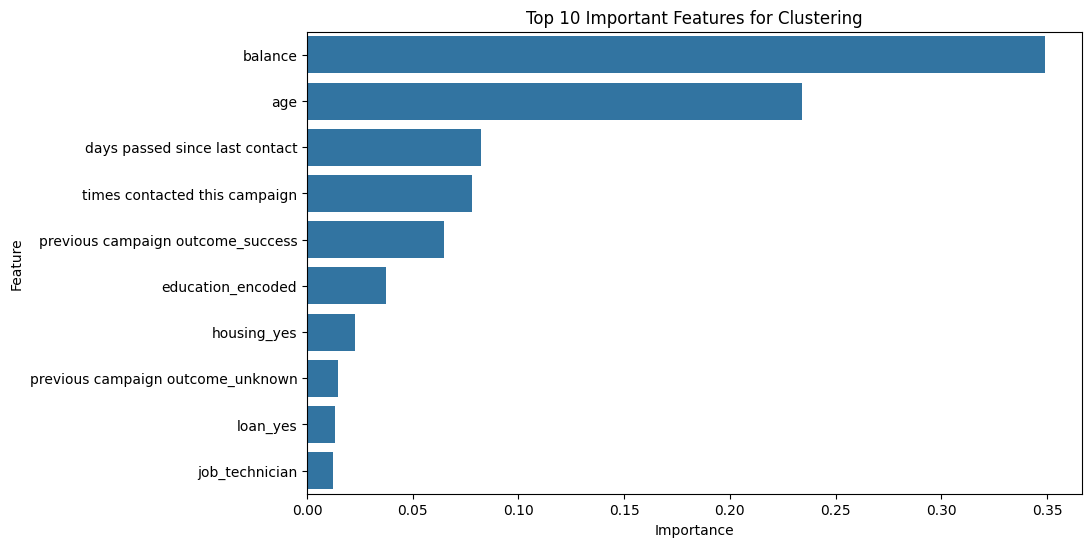

In [92]:
# Feature Importance Using Random Forest

# Get feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': A.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Important Features for Clustering')
plt.show()

In [93]:
# Model Evaluation
# Evaluate the clustering with silhouette score
sil_score = silhouette_score(A, y)
print(f'Silhouette Score: {sil_score:.3f}')

Silhouette Score: 0.083


In [ ]:
# SHAP Values for Model Explainability

# SHAP values for model explainability
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(A)

# Summary plot for feature importance (SHAP)
shap.summary_plot(shap_values[1], A)